<a href="https://colab.research.google.com/github/dlwub/Final_Project_AIMS/blob/main/Final_Project_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing Pandas

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from mlxtend.evaluate import feature_importance_permutation
import ipywidgets

## Random Forest Regression

In [ ]:
mergedData = pd.read_csv("/content/mergedData.csv")

In [ ]:
mergedData

,DATE,EXC,INT,PPI_IND,PPI_MNG,GDP,RSV,Tr_bal,FGEXPND,UNEPLT,M3,CPI
0,1993-01,3.0520,11.86,6.217269,23.817153,5.709373e+05,3.824631e+10,1.362182e+09,1522.365000,20.819,1.963190e+11,26.766563
1,1993-02,3.0520,11.39,5.819501,24.223590,5.722367e+05,3.632445e+10,-3.748388e+08,1525.796333,20.819,1.963817e+11,26.858544
2,1993-03,3.1700,11.34,5.421734,24.304877,5.735360e+05,4.096780e+10,2.989839e+08,1529.227667,20.819,1.968134e+11,27.226469
3,1993-04,3.1615,11.14,5.023967,24.670669,5.748354e+05,3.879606e+10,2.013539e+09,1532.659000,20.819,1.959147e+11,27.962320
4,1993-05,3.2470,11.50,5.024953,24.792600,5.772926e+05,3.854617e+10,1.601210e+09,1538.741000,20.819,1.961473e+11,28.054301
...,...,...,...,...,...,...,...,...,...,...,...,...
353,2022-06,16.3100,5.13,16.503959,157.150543,1.153956e+06,9.277200e+10,1.161394e+10,6038.098000,28.840,4.497885e+12,140.834927
354,2022-07,16.3100,5.40,17.121706,160.637039,1.160700e+06,9.086000e+10,2.191819e+10,6064.399000,28.840,4.554352e+12,143.130415
355,2022-08,17.0350,5.74,17.485309,159.862262,1.156467e+06,9.252500e+10,8.225106e+09,6101.502333,28.840,4.588004e+12,143.535501
356,2022-09,18.0750,5.78,17.848912,161.024427,1.152234e+06,9.167000e+10,2.382717e+10,6138.605667,28.840,4.640815e+12,143.670530


In [ ]:
def get_train_test_set(duration):
  dataset = mergedData.drop(mergedData.columns[0], axis=1)
  values = dataset.values
  X, y = values[:, :-1], values[:, -1:]
  train_size = mergedData.shape[0] - duration
  X_train = X[:train_size, :]
  X_test = X[train_size:, :]
  y_train = y[:train_size, :].flatten()
  y_test = y[train_size:, :].flatten()
  return X_train, y_train, X_test, y_test

In [ ]:
def random_forest_regressor(model, duration):
  X_train, y_train, X_test, y_test = get_train_test_set(duration)
  model.fit(X_train, y_train.ravel())
  train_pred = model.predict(X_train)
  test_pred = model.predict(X_test)
  return test_pred, y_test, train_pred, y_train

In [ ]:
def get_best_params(X_train, y_train):
  param_grid = {
    'n_estimators': [100, 200, 300, 400, 500, 1000]
}
  rf = RandomForestRegressor()
  grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
  grid_search.fit(X_train, y_train.ravel())
  return grid_search.best_params_

In [ ]:
def get_model(X_train, y_train):
  model = RandomForestRegressor(n_estimators=get_best_params(X_train, y_train)['n_estimators'])
  return model

### Feature Importance

In [ ]:
def plot_importance_graph():
  importance = model.feature_importances_
  indices = np.argsort(importance)
  plt.barh(range(X_train.shape[1]), importance[indices])
  plt.yticks(range(X_train.shape[1]), mergedData.columns[1:-1][indices], fontsize=12)
  plt.tight_layout()
  plt.xlabel('Feature Importance', fontsize=14)
  plt.ylabel('Features', fontsize=14)
  plt.show()

### Curve plot

In [ ]:
# Plot predicted vs real values with dates on the x-axis
def plot_RF(model, duration):
  X_train, y_train = get_train_test_set(duration)[0:2]
  test_pred, y_test = random_forest_regressor(model, duration)[0:2]
  test_date = mergedData.iloc[-duration:, 0]
  plt.figure(figsize=(10, 5))
  plt.plot(test_date, y_test, label='Real Values', marker='o')
  plt.plot(test_date, test_pred, label='Predicted Values', marker='x')
  plt.xlabel('Dates', fontsize=12)
  plt.ylabel('CPI', fontsize=14)
  #plt.title('Predicted vs Real Values RF model - %s prediction' %("test" if duration > 24 else "%d months" %duration))
  plt.xticks(rotation=45)
  plt.xticks(range(0, len(test_date), 6), test_date[::6], fontsize=12)
  plt.yticks(fontsize=12)
  results = {}

  mae = float(format(mean_absolute_error(y_test, test_pred.ravel()), '.2f'))
  rmse = float(format(np.sqrt(mean_squared_error(y_test, test_pred.ravel())), '.2f'))

  results[duration] = {'MAE': mae, 'RMSE': rmse}
  print(results)
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

In [ ]:
X_train, y_train, X_test, y_test = get_train_test_set(int(mergedData.shape[0]*0.2))

In [ ]:
model = get_model(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [ ]:
test_pred, y_test, train_pred, y_train = random_forest_regressor(model, int(mergedData.shape[0]*0.2))
df5 = pd.DataFrame({'Predicted value': test_pred, 'Real Value': y_test})
df5

,Predicted value,Real Value
0,107.757624,108.968156
1,107.496343,109.643299
2,107.198267,110.858557
3,107.113537,111.398672
4,107.300214,111.533701
...,...,...
66,106.197705,140.834927
67,106.177788,143.130415
68,106.349612,143.535501
69,106.415438,143.670530


### RMSE on train test set

In [ ]:
train_mae = float(format(mean_absolute_error(train_pred, y_train.ravel()),'.2f'))
test_mae = float(format(mean_absolute_error(y_test, test_pred.ravel()),'.2f'))
train_rmse = float(format(np.sqrt(mean_squared_error(train_pred, y_train.ravel())),'.2f'))
test_rmse = float(format(np.sqrt(mean_squared_error(y_test, test_pred.ravel())),'.2f'))
print("Mean Absolute Error on Training Data: {:.2f}".format(train_mae))
print("Mean Absolute Error on Testing Data: {:.2f}".format(test_mae))
print("Root Mean Squared Error on Training Data: {:.2f}".format(train_rmse))
print("Root Mean Squared Error on Testing Data: {:.2f}".format(test_rmse))

Mean Absolute Error on Training Data: 0.08
Mean Absolute Error on Testing Data: 17.95
Root Mean Squared Error on Training Data: 0.12
Root Mean Squared Error on Testing Data: 20.54


### Feature Importance graph

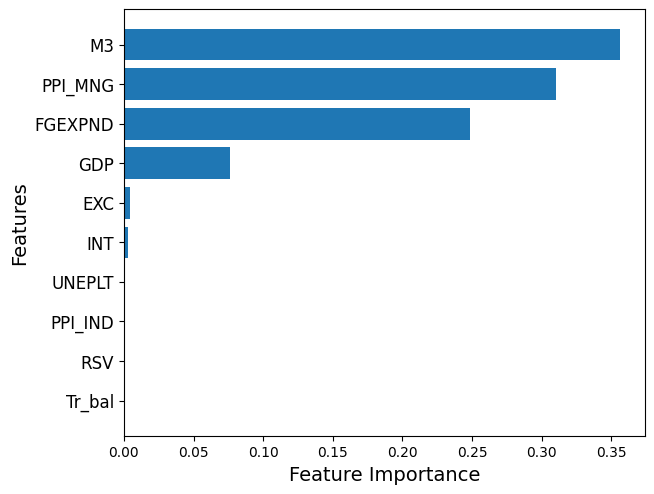

In [ ]:
plot_importance_graph()

{71: {'MAE': 17.96, 'RMSE': 20.59}}


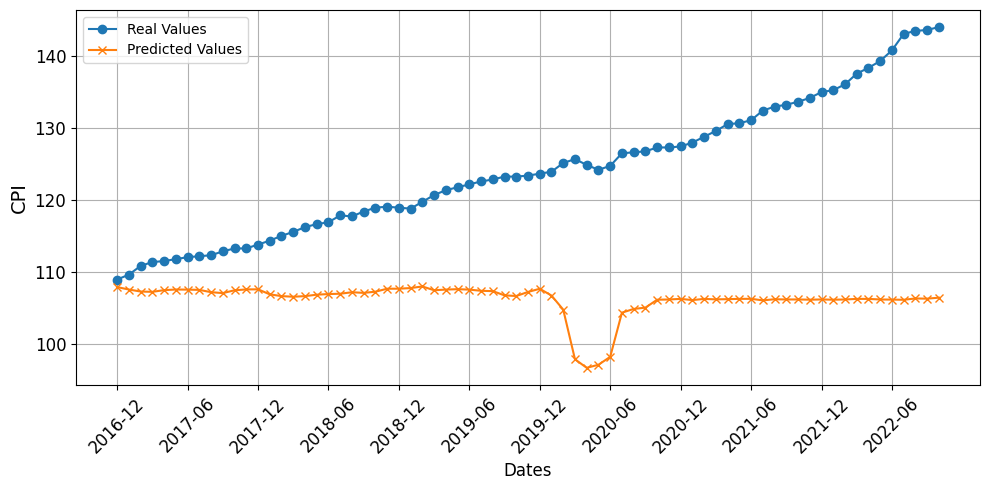

In [ ]:
plot_RF(model, int(mergedData.shape[0]*0.2))

### Forecast (Interactive plot)

In [ ]:
ipywidgets.interact(plot_RF, model=model, duration=ipywidgets.SelectionSlider(options=[1, 3, 6, 12, 24]))

interactive(children=(Dropdown(description='model', options=(DecisionTreeRegressor(max_features=1.0, random_st…

<function __main__.plot_RF(model, duration)>